**Laboratorio QCP**

In [ ]:
import numpy as np
from numpy.core.numeric import identity
import matplotlib.pyplot as plt
from numpy.random import randint
import math
!pip install qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, transpile, IBMQ, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
import qiskit.circuit.library as lib

     |████████████████████████████████| 6.4 MB 11.4 MB/s 
     |████████████████████████████████| 18.0 MB 621 kB/s 
     |████████████████████████████████| 238 kB 56.1 MB/s 
     |████████████████████████████████| 200 kB 49.9 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 1.6 MB 45.1 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 38.1 MB 62.6 MB/s 
     |████████████████████████████████| 943 kB 48.0 MB/s 
     |████████████████████████████████| 38.2 MB 2.2 MB/s 
     |████████████████████████████████| 3.6 MB 44.9 MB/s 
     |████████████████████████████████| 113 kB 69.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.1-py3-none-any.whl size=11771 sha256=1cb7c0d581f172ce608bcfeda4262aef9e3d4a66818f302bfea29734d47af3e4
  Stored in directory: /root/.cache/pip/wheels/79/b1/3f/8cdfd5543a84705e4bd16e081f2362b9b3bfd9898d2e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  


# Algebra Lineare

In [ ]:
# Gate X di Pauli
X=np.array([[0,1],[1,0]])

# matrice di Hadamard
H=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

# matrice di Hadamard generalizzata (ricorsiva)
def Had(n):
  if(n==1):
    return H
  return np.kron(H,Had(n-1))
print("matrice di Hadamard generalizzata ",Had(2))

# Gate Z di Pauli
Z=np.array([[1,0],[0,-1]])

# Matrice identita'
I=np.array([[1,0],[0,1]])

# Matrice identita' generalizzata (ricorsiva)
def Idt(n):
  if(n==1):
    return I
  return np.kron(I,Idt(n-1))
print("matrice identita' generalizzata ", Idt(4))

# Per normalizzare un vettore si deve moltiplicare per la sua norma, 
# per ottenere la norma si utilizza np.linalg.norm
def normalizza(v):
  v = v/np.linalg.norm(v)
  return v
# esempio
print("Normalizza ",normalizza([1,1]))

# dato un numero in binario vogliomo restituisto la sua forma canonica, ovvere tutti zero tranne un 1 alla posione del numero in binario
def get_state(bstr):
  if type(bstr)==str:
    n = len(bstr)
    N = 2**n
    state = [0]*N
    pos = int(bstr,2)
    state[pos]=1
    return np.array(state)
  if type(bstr)==list:
    state = list(bstr)
    return normalizza(np.array(state))
  if type(bstr)==int:
    state = np.random.rand(bstr)
    return normalizza(state)

#esempi
print("Get_state 1 ",get_state("010"))
print("Get_state 2 ",get_state([0,2,3,5]))
print("Get_random_state ",get_state(8))

# misurazione di un vettore
def counts(vec):
  print("COUNTS: ")
  N = len(vec)
  n = int(np.log2(N))
  formatstr = "{:0>"+str(n)+"b}"
  for i in range(N):
    if(vec[i]>0):
      print(" -",formatstr.format(i),str(np.around((vec[i]**2)*100,decimals=2))+"%")
#esempio
print(counts(normalizza(np.array([0,1,0,1]))))

# multi controlled CX
def mcx(n):
  N = 2**n
  M = Idt(n)
  M[-2],M[-1] = M[-1].copy(),M[-2].copy()
  return M
#esempio
print("multi controlled CX ",mcx(3))

# general CX
def gcx(c,t,n):
  mat = Idt(n)
  formatstr = "{:0>"+str(n)+"b}"
  for q in range(2**n):
    v = formatstr.format(q)
    if(v[c]=="0" and v[t]=="0"):
      b = [c for c in v]
      b[c]="1"
      control = int(''.join(b),2)
      b[t] = "1"
      target = int(''.join(b),2)
      trow = mat[target].copy()
      crow = mat[control].copy()
      mat[control] = trow
      mat[target] = crow
  return mat
#esempio
print("general CX ",gcx(0,2,3))

# general CCX
def gccx(c1,c2,t,n):
  mat = Idt(n)
  formatstr = "{:0>"+str(n)+"b}"
  for q in range(2**n):
    v = formatstr.format(q)
    if(v[c1]=="0" and v[c2]=="0" and v[t]=="0"):
      b = [c for c in v]
      b[c1]="1"
      b[c2]="1"
      control = int(''.join(b),2)
      b[t] = "1"
      target = int(''.join(b),2)
      trow = mat[target].copy()
      crow = mat[control].copy()
      mat[control] = trow
      mat[target] = crow
  return mat

def gSwap(r1,r2,n):
  CX1 = gcx(r2,r1,n)
  CX2 = gcx(r1,r2,n)
  CX3 = gcx(r2,r1,n)
  M = np.matmul(CX1,CX2)
  M = np.matmul(M,CX3)
  return M
#esempio
Inp = get_state("0011")
Out = np.matmul(gSwap(0,2,4),Inp)
print("General Swap ",counts(Out))

# tensor product tra piu' array
def tp(ql):
  v = ql[0]
  for i in range(1,len(ql)):
    v = np.kron(v,ql[i])
  return v

# halfAdder
def halfAdder(b0,b1):
  inp0 = get_state(str(b0))
  inp1 = get_state(str(b1))
  out0 = get_state("0")
  out1 = get_state("0")

  a1 = tp([inp0,inp1,out0,out1])
  a2 = np.matmul(gcx(0,2,4),a1)
  a3 = np.matmul(gcx(1,2,4),a2)
  a4 = np.matmul(gccx(0,1,3,4),a3)
  return counts(a4)
# esempio
print("halfAdder(1,0): ",halfAdder(1,0))
print("halfAdder(1,1): ",halfAdder(1,1))

matrice di Hadamard generalizzata  [[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]
matrice identita' generalizzata  [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
Normalizza  [0.70710678 0.70710678]
Get_state 1  [0 0 1 0 0 0 0 0]
Get_state 2  [0.         0.32444284 0.48666426 0.81110711]
Get_random_state  [0.60781526 0.03863365 0.30221416 0.25291184 0.58923034 0.07031781
 0.13848213 0.32008743]
COUNTS: 
 - 01 50.0%
 - 11 50.0%
None
multi

# Algoritmi di Base:

## Half e Full Adder

              ░ ┌───┐                ░                 ░       
 input_0: |0>─░─┤ X ├──■─────────■───░─────────────────░───────
              ░ ├───┤  │         │   ░                 ░       
 input_1: |0>─░─┤ X ├──┼────■────■───░─────────────────░───────
              ░ ├───┤  │    │    │   ░                 ░       
 input_2: |0>─░─┤ X ├──┼────┼────┼───░───■─────────■───░───────
              ░ └───┘┌─┴─┐┌─┴─┐  │   ░   │         │   ░       
 ancilla: |0>─░──────┤ X ├┤ X ├──┼───░───┼────■────■───░───────
              ░      └───┘└───┘  │   ░ ┌─┴─┐┌─┴─┐  │   ░ ┌─┐   
output_0: |0>─░──────────────────┼───░─┤ X ├┤ X ├──┼───░─┤M├───
              ░                ┌─┴─┐ ░ └───┘└───┘┌─┴─┐ ░ └╥┘┌─┐
output_1: |0>─░────────────────┤ X ├─░───────────┤ X ├─░──╫─┤M├
              ░                └───┘ ░           └───┘ ░  ║ └╥┘
   clas: 0 2/═════════════════════════════════════════════╩══╩═
                                                          0  1 


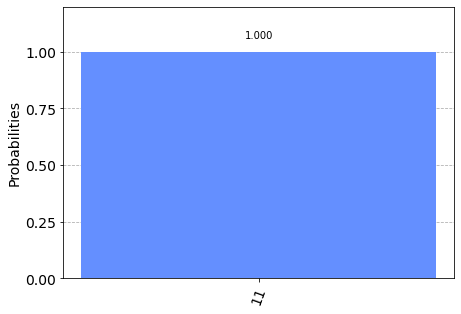

In [ ]:
def halfadder(l):
  n = len(l)
  input = QuantumRegister(n,"input")
  output = QuantumRegister(2,"output")
  cl = ClassicalRegister(2,"clas")
  circuit = QuantumCircuit(input,output,cl)
  circuit.barrier()
  for i in range(n):
    if(int(l[i])==1):
      circuit.x(i)
  circuit.cx(0,2)
  circuit.cx(1,2)
  circuit.ccx(0,1,3)
  circuit.barrier()
  circuit.measure(output[0],cl[0])
  circuit.measure(output[1],cl[1])
  print(circuit.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  qobj = assemble(circuit, aer_sim)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  return answer

def fulladder(l):
  n = len(l)
  if(n!=3):
    return print("Lunghezza stringa errata.")
  input = QuantumRegister(n,"input")
  output = QuantumRegister(2,"output")
  ancilla = QuantumRegister(1,"ancilla")
  cl = ClassicalRegister(2,"clas")
  circuit = QuantumCircuit(input,ancilla,output,cl)
  circuit.barrier()
  for i in range(n):
    if(int(l[i])==1):
      circuit.x(i)
  circuit.cx(input[0],ancilla[0])
  circuit.cx(input[1],ancilla[0])
  circuit.ccx(input[0],input[1],output[1])
  circuit.barrier()
  circuit.cx(input[2],output[0])
  circuit.cx(ancilla[0],output[0])
  circuit.ccx(input[2],ancilla[0],output[1])
  circuit.barrier()
  circuit.measure(output[0],cl[0])
  circuit.measure(output[1],cl[1])
  print(circuit.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  qobj = assemble(circuit, aer_sim)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  return answer

result=fulladder("111")
plot_histogram(result)

## Testa o Croce

         ░ ┌───┐┌─┐ ░ 
 input: ─░─┤ H ├┤M├─░─
         ░ └───┘└╥┘ ░ 
clas: 1/═════════╩════
                 0    


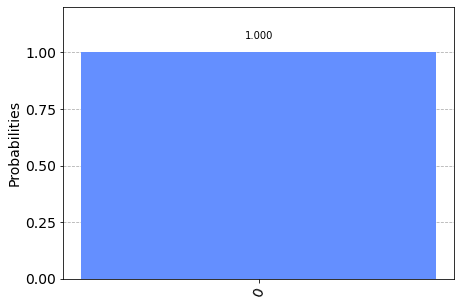

In [ ]:
def ToC():
  coin = QuantumRegister(1,"input")
  c = ClassicalRegister(1, "clas")
  qc = QuantumCircuit(coin, c)
  qc.barrier()
  qc.h(coin)
  qc.measure(coin,c)
  qc.barrier()
  print(qc.draw())
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 1
  qobj = assemble(qc, shots=shots)
  results = aer_sim.run(qobj).result()
  counts = results.get_counts()
  return counts

plot_histogram(ToC())

## Generazione di un numero random

In [ ]:
#GENERAZIONE DI UN NUMERO RANDOM
def rand_n(n):
  inp = QuantumRegister(n, "input")
  cla = ClassicalRegister(n, "cla")
  qc = QuantumCircuit(inp,cla)
  for i in range(n):
    qc.h(inp[i])
  for i in range(n):
    qc.measure(inp[i],cla[i])
  print(qc.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 1
  qobj = assemble(qc, shots=shots)
  results = aer_sim.run(qobj).result()
  counts = results.get_counts()
  result = int(list(counts.keys())[0],2)
  return result

print("Generato il numero random: ", rand_n(3))

            ┌───┐┌─┐      
input_0: |0>┤ H ├┤M├──────
            ├───┤└╥┘┌─┐   
input_1: |0>┤ H ├─╫─┤M├───
            ├───┤ ║ └╥┘┌─┐
input_2: |0>┤ H ├─╫──╫─┤M├
            └───┘ ║  ║ └╥┘
   cla: 0 3/══════╩══╩══╩═
                  0  1  2 
Generato il numero random:  6


## Generazione di n qubit correlati:

          ┌───┐ ░ ┌───┐ ░       ░ ┌─┐   
inp_0: |0>┤ X ├─░─┤ H ├─░───■───░─┤M├───
          └───┘ ░ └───┘ ░ ┌─┴─┐ ░ └╥┘┌─┐
inp_1: |0>──────░───────░─┤ X ├─░──╫─┤M├
                ░       ░ └───┘ ░  ║ └╥┘
 cla: 0 2/═════════════════════════╩══╩═
                                   0  1 


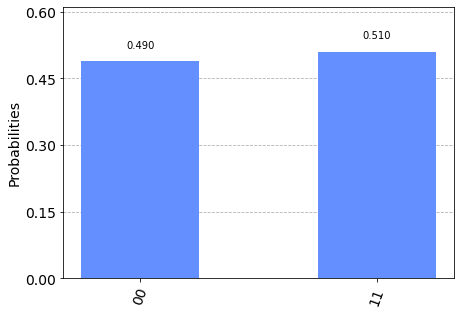

In [ ]:
def super_n(l):
  n = len(l)
  inp = QuantumRegister(n,"inp")
  cla = ClassicalRegister(n,"cla")
  qc = QuantumCircuit(inp,cla)
  for i in range(n):
    if(int(l[i])==1):
      qc.x(i)
  qc.barrier()
  qc.h(inp[0])
  qc.barrier()
  for i in range(1,n):
    qc.cx(0,inp[i])
  qc.barrier()

  for i in range(n):
    qc.measure(inp[i],cla[i])

  print(qc.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 100
  qobj = assemble(qc, shots=shots)
  results = aer_sim.run(qobj).result()
  counts = results.get_counts()

  return counts

plot_histogram(super_n("10"))

## Swap tra 2 qubit

            ┌───┐     ┌───┐     ┌─┐   
input_0: |0>┤ X ├──■──┤ X ├──■──┤M├───
            └───┘┌─┴─┐└─┬─┘┌─┴─┐└╥┘┌─┐
input_1: |0>─────┤ X ├──■──┤ X ├─╫─┤M├
                 └───┘     └───┘ ║ └╥┘
   cla: 0 2/═════════════════════╩══╩═
                                 1  0 


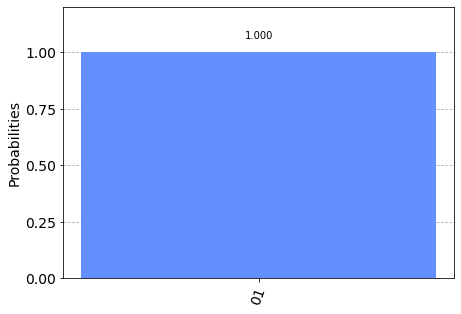

In [ ]:
def swap_q(l):
  n = len(l)
  inp = QuantumRegister(n,"input")
  cla = ClassicalRegister(n,"cla")
  qc = QuantumCircuit(inp,cla)
  if(int(l[0])==1):
    qc.x(inp[0])
  if(int(l[1])==1):
    qc.x(inp[1])
  qc.cx(inp[0],inp[1])
  qc.cx(inp[1],inp[0])
  qc.cx(inp[0],inp[1])
  qc.measure(inp[0],cla[1])
  qc.measure(inp[1],cla[0])

  print(qc.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 1
  qobj = assemble(qc, shots=shots)
  results = aer_sim.run(qobj).result()
  counts = results.get_counts()

  return counts

plot_histogram(swap_q("10"))

## And generalizzato

            ┌───┐ ░       ░    
input_0: |0>┤ X ├─░───■───░────
            └───┘ ░   │   ░    
input_1: |0>──────░───■───░────
            ┌───┐ ░   │   ░    
input_2: |0>┤ X ├─░───■───░────
            └───┘ ░ ┌─┴─┐ ░ ┌─┐
 output: |0>──────░─┤ X ├─░─┤M├
                  ░ └───┘ ░ └╥┘
     c: 0 1/═════════════════╩═
                             0 


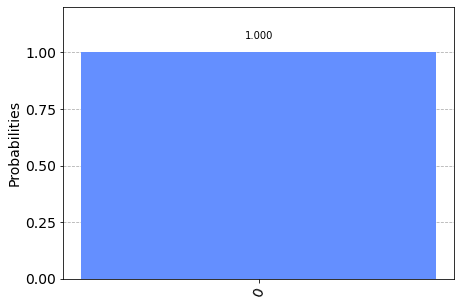

In [ ]:
def and_g(l):
  n=len(l)
  input = QuantumRegister(n,"input")
  output = QuantumRegister(1,"output")
  cl = ClassicalRegister(1,"c")
  circuit = QuantumCircuit(input,output,cl)
  for i in range(n):
    if(int(l[i])==1):
      circuit.x(i)
  circuit.barrier()
  circuit.mcx(list(range(n)),n)
  circuit.barrier()
  circuit.measure(output,cl)
  
  print(circuit.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  qobj = assemble(circuit, aer_sim)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  return answer
  
result=and_g("101")
plot_histogram(result)

## Or Generalizzato

             ░       ░ ┌───┐ ░       ░ ┌───┐ ░    
input_0: |0>─░───────░─┤ X ├─░───■───░─┤ X ├─░────
             ░ ┌───┐ ░ ├───┤ ░   │   ░ ├───┤ ░    
input_1: |0>─░─┤ X ├─░─┤ X ├─░───■───░─┤ X ├─░────
             ░ └───┘ ░ ├───┤ ░   │   ░ ├───┤ ░    
input_2: |0>─░───────░─┤ X ├─░───■───░─┤ X ├─░────
             ░       ░ └───┘ ░ ┌─┴─┐ ░ ├───┤ ░ ┌─┐
 output: |0>─░───────░───────░─┤ X ├─░─┤ X ├─░─┤M├
             ░       ░       ░ └───┘ ░ └───┘ ░ └╥┘
     c: 0 1/════════════════════════════════════╩═
                                                0 


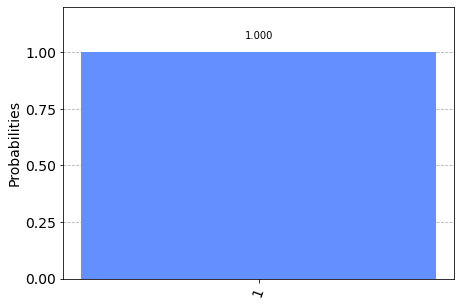

In [ ]:
def or_g(l):
  n=len(l)
  input = QuantumRegister(n,"input")
  output = QuantumRegister(1,"output")
  cl = ClassicalRegister(1,"c")
  qc = QuantumCircuit(input,output,cl)
  qc.barrier()
  for i in range(n):
    if(int(l[i])==1):
      qc.x(i)
  qc.barrier()
  for i in range(n):
    qc.x(i)
  qc.barrier()
  qc.mcx(list(range(n)),n)
  qc.barrier()
  for i in range(n+1):
    qc.x(i)
  
  qc.barrier()
  qc.measure(output,cl)
  
  print(qc.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  qobj = assemble(qc, aer_sim)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  return answer
  
result=or_g("010")
plot_histogram(result)

## Xor Generalizzato

           ┌───┐ ░                           ░    
 inp_0: |0>┤ X ├─░───■───────────────────────░────
           ├───┤ ░   │                       ░    
 inp_1: |0>┤ X ├─░───┼────■──────────────────░────
           └───┘ ░   │    │                  ░    
 inp_2: |0>──────░───┼────┼────■─────────────░────
           ┌───┐ ░   │    │    │             ░    
 inp_3: |0>┤ X ├─░───┼────┼────┼────■────────░────
           └───┘ ░   │    │    │    │        ░    
 inp_4: |0>──────░───┼────┼────┼────┼────■───░────
                 ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ ┌─┐
output: |0>──────░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤M├
                 ░ └───┘└───┘└───┘└───┘└───┘ ░ └╥┘
  cla: 0 1/═════════════════════════════════════╩═
                                                0 


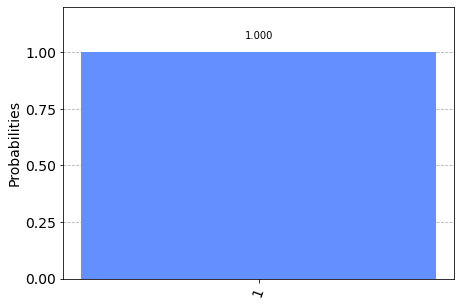

In [ ]:
def xor_g(l):
  n = len(l)
  inp = QuantumRegister(n,"inp")
  out = QuantumRegister(1,"output")
  cla = ClassicalRegister(1, "cla")
  qc = QuantumCircuit(inp,out,cla)
  for i in range(n):
    if(int(l[i])==1):
      qc.x(inp[i])
  qc.barrier()
  for i in range(n):
    qc.cx(inp[i],out)
  qc.barrier()

  qc.measure(out,cla)

  print(qc.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  qobj = assemble(qc, aer_sim)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  return answer
  
plot_histogram(xor_g("11010"))

## Boolean Inner Product

              ┌───┐ ░                 ░                   
 input1_0: |0>┤ X ├─░───■─────────────░───────────────────
              └───┘ ░   │             ░                   
 input1_1: |0>──────░───┼────■────────░───────────────────
              ┌───┐ ░   │    │        ░                   
 input1_2: |0>┤ X ├─░───┼────┼────■───░───────────────────
              ├───┤ ░   │    │    │   ░                   
 input2_0: |0>┤ X ├─░───■────┼────┼───░───────────────────
              ├───┤ ░   │    │    │   ░                   
 input2_1: |0>┤ X ├─░───┼────■────┼───░───────────────────
              ├───┤ ░   │    │    │   ░                   
 input2_2: |0>┤ X ├─░───┼────┼────■───░───────────────────
              └───┘ ░ ┌─┴─┐  │    │   ░                   
ancilla_0: |0>──────░─┤ X ├──┼────┼───░───■───────────────
                    ░ └───┘┌─┴─┐  │   ░   │               
ancilla_1: |0>──────░──────┤ X ├──┼───░───┼────■──────────
                    ░      └───┘┌─┴─┐ ░   │    │        

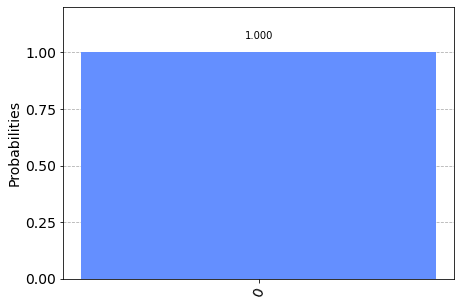

In [ ]:
#BOOLEAN INNER PRODUCT
def bip(l1,l2):
  n = len(l1)
  input1 = QuantumRegister(n,"input1")
  input2 = QuantumRegister(n,"input2")
  ancilla = QuantumRegister(n,"ancilla")
  out = QuantumRegister(1,"output")
  cla = ClassicalRegister(1,"cla")
  qc = QuantumCircuit(input1,input2,ancilla,out,cla)
  for i in range(n):
    if(int(l1[i])==1):
      qc.x(input1[i])
    if(int(l2[i])==1):
      qc.x(input2[i])
  qc.barrier()
  for i in range(n):
    qc.ccx(input1[i],input2[i],ancilla[i])
  qc.barrier()
  for i in range(n):
    qc.cx(ancilla[i],out)
  qc.barrier
  qc.measure(out,cla)
  print(qc.draw(initial_state=True))
  aer_sim = Aer.get_backend('aer_simulator')
  qobj = assemble(qc, aer_sim)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  return answer
  
plot_histogram(bip("101","111"))

# Quantum Teleportation & Superdense Coding

## Quantum Teleportation

global phase: 5.2472
             ┌───────────────────────────────────────────┐ ░            ░      »
       mess: ┤ init(-0.067745+0.67669j,0.67489+0.28641j) ├─░────────────░───■──»
             └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐»
alice_qubit: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├»
                                                           ░ └───┘┌─┴─┐ ░ └───┘»
  bob_qubit: ──────────────────────────────────────────────░──────┤ X ├─░──────»
                                                           ░      └───┘ ░      »
      crz: 1/══════════════════════════════════════════════════════════════════»
                                                                               »
      crx: 1/══════════════════════════════════════════════════════════════════»
                                                                               »
      ver: 1/══════════════════════════════════════════════════════════════════»
       

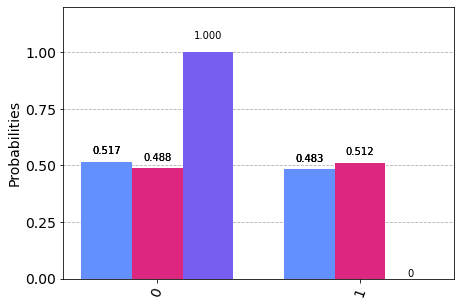

In [ ]:
#QUANTUM TELEPORTATION 
def random_state():
  return random_statevector(2)

def bell_pair():
  qc = QuantumCircuit(2)
  qc.h(0)
  qc.cx(0,1)
  return qc

def alice():
  mess = QuantumRegister(1,name="mess")
  aq = QuantumRegister(1,name="alice_qubit")
  bq = QuantumRegister(1,name="bob_qubit")
  cr = ClassicalRegister(2,name="code_mess")
  qc = QuantumCircuit(mess,aq,bq,cr)
  qc.cx(mess,aq)
  qc.h(mess)
  qc.barrier()
  qc.measure(mess,cr[0])
  qc.measure(aq,cr[1])
  return qc

def bob():
  bq = QuantumRegister(1,name="bob_qubit")
  cr = ClassicalRegister(2,name="clas")
  qc = QuantumCircuit(bq,cr)
  qc.x(bq).c_if(cr[1],1)
  qc.z(bq).c_if(cr[0],1)
  return qc

def teleport(psi):
  aq = QuantumRegister(1,name="alice_qubit")
  bq = QuantumRegister(1,name="bob_qubit")
  mess = QuantumRegister(1,name="mess")
  crz = ClassicalRegister(1,name="crz")
  crx = ClassicalRegister(1,name="crx")
  ver = ClassicalRegister(1,name="ver")
  qc = QuantumCircuit(mess,aq,bq,crz,crx,ver)
  init_gate = Initialize(psi)
  init_gate.label = "init"
  inverse_init_gate = init_gate.gates_to_uncompute()
  qc = qc.compose(init_gate,[mess])
  qc.barrier()
  qc = qc.compose(bell_pair(),[aq[0],bq[0]])
  qc.barrier()
  qc = qc.compose(alice(),[mess[0],aq[0],bq[0]],[crz[0],crx[0]])
  qc.barrier()
  qc = qc.compose(bob(),[bq[0]],[crz[0],crx[0]])
  qc.barrier()
  qc = qc.compose(inverse_init_gate, [bq[0]])
  qc.measure(bq[0],ver[0])
  print(qc.draw())
  sim = Aer.get_backend('aer_simulator')
  t_qc = transpile(qc, sim)
  t_qc.save_statevector()
  counts = sim.run(t_qc).result().get_counts()
  qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
  return qubit_counts

psi=random_state()
plot_histogram(teleport(psi))

## SuperDense Coding

             ┌───┐ ░ ┌───┐ ░ ┌───┐      ░ ┌─┐   
   q_0: ─────┤ X ├─░─┤ X ├─░─┤ X ├──────░─┤M├───
        ┌───┐└─┬─┘ ░ └───┘ ░ └─┬─┘┌───┐ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░───────░───■──┤ H ├─░──╫─┤M├
        └───┘      ░       ░      └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1 
{'01': 1024}


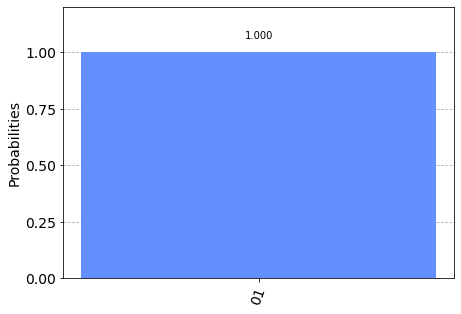

In [ ]:
#SUPERDENSE CODING
def create_bell_pair():
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1,0)
    return qc

def encode_message(qc, qubit, msg):
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

def decode_message(qc):
    qc.cx(1,0)
    qc.h(1)
    return qc

qc = create_bell_pair()
qc.barrier()
message = '01'
qc = encode_message(qc, 0, message)
qc.barrier()
qc = decode_message(qc)
qc.measure_all()
print(qc.draw())
#LANCIAMO IL SIMULATORE
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

# Quantum Key Distribution - BB84

In [ ]:
#BB84
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0:
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else:
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        #Simulatore
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            good_bits.append(bits[q])
    return good_bits

def sample_bits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits))
        sample.append(bits.pop(i))
    return sample

np.random.seed(seed=0)
n = 100
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
'''
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
'''
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))
if bob_sample != alice_sample:
    print("Eva ha intercettato.")
else: print("Eve non ha intercettato")

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Eve non ha intercettato


# Deutsch-Jozsa

0110
oracle:                                
q_0: ───────■─────────────────
     ┌───┐  │       ┌───┐     
q_1: ┤ X ├──┼────■──┤ X ├─────
     ├───┤  │    │  └───┘┌───┐
q_2: ┤ X ├──┼────┼────■──┤ X ├
     └───┘  │    │    │  └───┘
q_3: ───────┼────┼────┼────■──
          ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q_4: ─────┤ X ├┤ X ├┤ X ├┤ X ├
          └───┘└───┘└───┘└───┘
     ┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


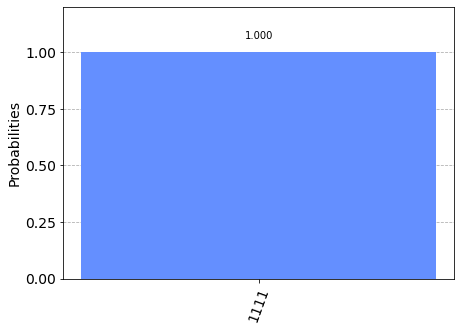

In [ ]:
#DEUTSCH-JOZSA
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    if case == "balanced":
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
    if case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    print("Oracle: ",oracle_qc.draw())
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    dj_circuit.x(n)
    dj_circuit.h(n)
    for qubit in range(n):
        dj_circuit.h(qubit)
    dj_circuit.append(oracle, range(n+1))
    for qubit in range(n):
        dj_circuit.h(qubit)
    for i in range(n):
        dj_circuit.measure(i, i)
    return dj_circuit

n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
print(dj_circuit.draw())
#Simulazione
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

# Bernstein-Vazirani

     ┌───┐      ░                      ░ ┌───┐┌─┐         
q_0: ┤ H ├──────░───■──────────────────░─┤ H ├┤M├─────────
     ├───┤      ░   │                  ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├──────░───┼─────────■────────░─┤ H ├─╫─┤M├──────
     ├───┤      ░   │  ┌───┐  │        ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├──────░───┼──┤ I ├──┼────────░─┤ H ├─╫──╫─┤M├───
     ├───┤      ░   │  └───┘  │        ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░───┼─────────┼────■───░─┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐     ┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║  ║ └╥┘
q_4: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├┤ X ├─░───────╫──╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘└───┘ ░       ║  ║  ║  ║ 
c: 4/══════════════════════════════════════════╩══╩══╩══╩═
                                               0  1  2  3 
Risultato corretto


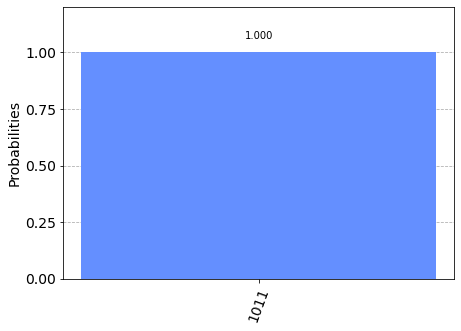

In [ ]:
#BERNSTEIN-VAZIRANI
s = '1011'   # the hidden binary string
n = len(s) # number of qubits used to represent s

# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

print(bv_circuit.draw())

# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

sn=list(answer)[0][::-1]
if(sn==s):
  print("Risultato corretto")
else:
  print("Errore, le stringhe non combaciano: ",sn,"-",s)

plot_histogram(answer)

# Simon

     ┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■──────────────■────■───░─┤ H ├┤M├──────
     ├───┤ ░   │              │    │   ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────┼────┼───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │  ┌─┴─┐  │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼──┤ X ├──┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  └───┘  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼─────────┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐     ┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2 


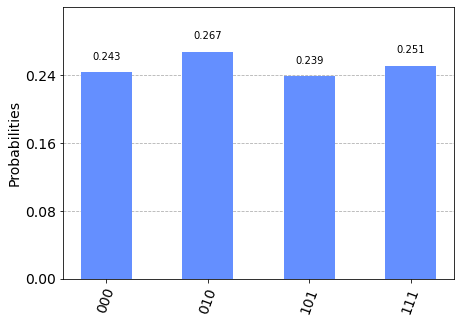

In [ ]:
#SIMON
def simon_o(b):
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)
    if '1' not in b: 
        return qc  # 1:1 mapping, so just exit
    i = b.find('1') # index of first non-zero bit in b
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc 

b = '101'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)
simon_circuit.h(range(n))    
simon_circuit.barrier()
simon_circuit = simon_circuit.compose(simon_o(b))
simon_circuit.barrier()
simon_circuit.h(range(n))
simon_circuit.measure(range(n), range(n))
print(simon_circuit.draw())
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

# Grover

In [ ]:
#GROVER, ALGEBRA
def Refl(n):
  s = [1]*(2**n)
  s = s/np.linalg.norm(s)
  s = np.array([list(s)])
  m = np.matmul(np.transpose(s),s)
  m = 2*m - identity(2**n)
  return m

def PhaseO(w):
  n = len(w)
  P = identity(2**n)
  i = int(w,2)
  P[i,i] = -1
  return P

def Grover(w):
  n = len(w)
  N = 2**n
  iter = int((np.pi/4)*np.sqrt(N))
  P = PhaseO(w)
  R = Refl(n)
  print("Iterazioni: ", iter)
  u = [1]*N
  s = u/np.linalg.norm(u)
  for i in range(iter):
    s = np.matmul(P,s)
    s = np.matmul(R,s)
  print(s)
  i = int(w,2)
  print((s[i]**2)*100, "%")

Grover("1110")

Iterazioni:  2
[-0.35355339  0.35355339 -0.35355339 -0.35355339 -0.35355339 -0.35355339
  0.35355339 -0.35355339]
12.499999999999996 %


# QFT

     ┌───┐  ┌────────┐        ░                                         »
q_0: ┤ H ├──┤ P(29π) ├─────X──░─────────────────────────────────────────»
     ├───┤┌─┴────────┴┐    │  ░                                         »
q_1: ┤ H ├┤ P(45.553) ├─X──┼──░─────────────────────────────────────────»
     ├───┤├───────────┤ │  │  ░                                         »
q_2: ┤ H ├┤ P(22.777) ├─┼──┼──░──────────────────────■─────────■────────»
     ├───┤├───────────┤ │  │  ░                ┌───┐ │         │P(-π/2) »
q_3: ┤ H ├┤ P(11.388) ├─X──┼──░───────■────────┤ H ├─┼─────────■────────»
     ├───┤├───────────┤    │  ░ ┌───┐ │P(-π/2) └───┘ │P(-π/4)           »
q_4: ┤ H ├┤ P(5.6941) ├────X──░─┤ H ├─■──────────────■──────────────────»
     └───┘└───────────┘       ░ └───┘                                   »
c: 5/═══════════════════════════════════════════════════════════════════»
                                                                        »
«                                     

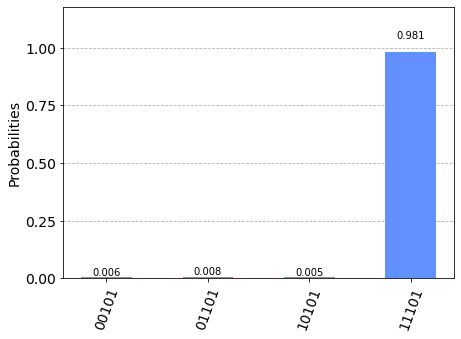

In [ ]:
#QUANTUM FOURIER TRANSFORM
def QFT(n):
  qc = QuantumCircuit(n)
  for t in range(n):
    qc.h(t)
    i = 1
    for c in range(t+1,n):
      phase = np.pi/(2**i)
      qc.cp(phase, c, t)
      i = i*2
  qc.barrier()
  #operiamo gli swap
  for q in range(int(n/2)):
    qc.swap(q, n-1-q)
  return qc

#inizializza uno specifico 
#valore nella base di Fourier
def Init_QFT(val,n):
  qc = QuantumCircuit(n)
  for q in range(n):
    qc.h(q)
    phase = (np.pi/2**q)*val
    qc.p(phase,q)
  return qc

def Test_QFT(val, n):
  qc = QuantumCircuit(n,n)
  qc = qc.compose(Init_QFT(val,n))
  Inverse_QFT = QFT(n).inverse()
  qc = qc.compose(Inverse_QFT)
  qc.barrier()
  #procediamo con le misurarazioni
  for q in range(n):
    qc.measure(q, n-1-q)
  print(qc.draw())
  #lanciamo il simulatore
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 1024
  qobj = assemble(qc, shots=shots)
  results = aer_sim.run(qobj).result()
  counts = results.get_counts()
  plot_histogram(counts)
  return counts
  
plot_histogram(Test_QFT(29,5))

# Quantum Phase Estimation

             ┌───┐ ░                                                   »
  phase_r_0: ┤ H ├─░──■─────────■─────────■─────────■──────────────────»
             ├───┤ ░  │         │         │         │                  »
  phase_r_1: ┤ H ├─░──┼─────────┼─────────┼─────────┼─────────■────────»
             ├───┤ ░  │         │         │         │         │        »
  phase_r_2: ┤ H ├─░──┼─────────┼─────────┼─────────┼─────────┼────────»
             ├───┤ ░  │P(5π/4)  │P(5π/4)  │P(5π/4)  │P(5π/4)  │P(5π/4) »
         gr: ┤ X ├─░──■─────────■─────────■─────────■─────────■────────»
             └───┘ ░                                                   »
classical: 3/══════════════════════════════════════════════════════════»
                                                                       »
«                                     ░                               »
«  phase_r_0: ─────────────────────X──░──────────────────────■────────»
«                                  │  ░              

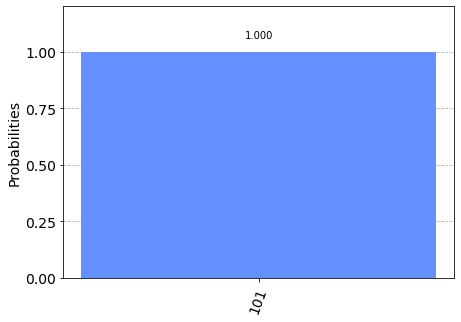

In [ ]:
def QFT(n):
  qc = QuantumCircuit(n)
  for t in range(n):
    qc.h(t)
    i = 1
    for c in range(t+1,n):
      phase = np.pi/(2**i)
      qc.cp(phase, c, t)
      i = i*2
  qc.barrier()
  #operiamo gli swap
  for q in range(int(n/2)):
    qc.swap(q, n-1-q)
    qc.cp
  return qc

#Di seguito la funzione che individua e stimare la fase 
#di un operatore (gate) quantistico. 
#Oltre al gate prende in input il numero dei qubit per il contatore,
# e il numero m di qubit su cui opera l'operatore
def QFE(n, m=1):
  phase_r = QuantumRegister(n,"phase_r")
  gr = QuantumRegister(m,"gr")
  cla = ClassicalRegister(n, "classical")
  qpe = QuantumCircuit(phase_r,gr,cla)
  qpe.h(phase_r)
  qpe.x(gr)
  qpe.barrier()
  for counting_qubit in range(n):
    for i in range(2**(n-counting_qubit-1)):
      qpe.cp(5*math.pi/4, counting_qubit, n); # This is CU
  Inverse_QFT = QFT(n).inverse()
  qpe = qpe.compose(Inverse_QFT)
  qpe.barrier()
  #procediamo con le misurarazioni
  for q in range(n):
    qpe.measure(q, n-1-q)
  print(qpe.draw())
  #lanciamo il simulatore
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 1024
  qobj = assemble(qpe, shots=shots)
  results = aer_sim.run(qobj).result()
  counts = results.get_counts()
  #Stima della fase:
  c_list=list(counts)
  c_list.sort(reverse=True)
  theta = c_list[0]
  val = int(theta, 2)
  val = 2*val/2**n
  print("Rotazione: ",str(val)+" pi greco")
  return counts
plot_histogram(QFE(3))

# Quantum Counting

      ┌───┐                                                        »
pr_0: ┤ H ├──────■─────────────■─────────────■─────────────■───────»
      ├───┤      │             │             │             │       »
pr_1: ┤ H ├──────┼─────────────┼─────────────┼─────────────┼───────»
      ├───┤      │             │             │             │       »
pr_2: ┤ H ├──────┼─────────────┼─────────────┼─────────────┼───────»
      ├───┤      │             │             │             │       »
pr_3: ┤ H ├──────┼─────────────┼─────────────┼─────────────┼───────»
      ├───┤      │             │             │             │       »
pr_4: ┤ H ├──────┼─────────────┼─────────────┼─────────────┼───────»
      ├───┤┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐»
gr_0: ┤ H ├┤0           ├┤0           ├┤0           ├┤0           ├»
      ├───┤│            ││            ││            ││            │»
gr_1: ┤ H ├┤1           ├┤1           ├┤1           ├┤1           ├»
      ├───┤│            ││        

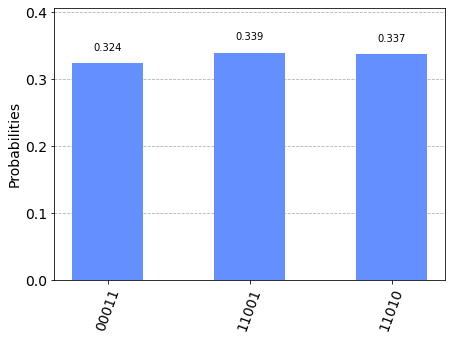

In [ ]:
def QFT(n):
  qc = QuantumCircuit(n)
  for t in range(n):
    qc.h(t)
    i = 1
    for c in range(t+1,n):
      phase = np.pi/(2**i)
      qc.cp(phase, c, t)
      i = i*2
  #operiamo gli swap
  for q in range(int(n/2)):
    qc.swap(q, n-1-q)
    qc.cp
  return qc

def GeneralPhaseOracle(wl):
  n = len(wl[0])
  qc = QuantumCircuit(n)
  for sol in wl:
    for i in range(n):
      if(sol[i]=='0'):
        qc.x(i)
    qc.h(n-1)
    qc.mcx(list(range(n-1)),n-1)
    qc.h(n-1)
    for i in range(n):
      if(sol[i]=='0'):
        qc.x(i)
  return qc

def Diffuser(n):
  s = '0'*n
  xr = QuantumRegister(n)
  qc = QuantumCircuit(xr)
  qc.h(xr)
  qc = qc.compose(GeneralPhaseOracle([s]))
  qc.h(xr)
  return qc

def Grover_op(wl):
  n = len(wl[0])
  qc = QuantumCircuit(n)
  qc = qc.compose(GeneralPhaseOracle(wl))
  qc = qc.compose(Diffuser(n))
  return qc

def CountSol(gate, n, m):
  cgate = gate.control()
  pr = QuantumRegister(n,"pr")
  gr = QuantumRegister(m,"gr")
  cr = ClassicalRegister(n, "cr")
  qc = QuantumCircuit(pr,gr,cr)

  qc.h(pr)
  qc.h(gr)

  #Applichiamo i gate controllati di Grover
  for i in range(n):
    for r in range(2**(n-i-1)):
      qc = qc.compose(cgate, [pr[i]]+[gr[q] for q in range(m)])

  #Importiamo la QFT inversa
  Inverse_QFT = QFT(n).inverse().to_gate()
  Inverse_QFT.label = "QFT†"
  qc = qc.compose(Inverse_QFT,pr)

  #procediamo con le misurarazioni
  for q in range(n):
    qc.measure(pr[q], cr[n-q-1])
  print(qc.draw())

  #lanciamo il simulatore
  aer_sim = Aer.get_backend('aer_simulator')
  transpiled_qc = transpile(qc, aer_sim)
  qobj = assemble(transpiled_qc)
  job = aer_sim.run(qobj)
  hist = job.result().get_counts()
  print(hist)

  #Stima numero di soluzioni:
  val = max(hist, key=hist.get)
  vmisurato = int(val, 2)
  theta = np.pi*(2*vmisurato)/2**n
  print("Theta: ",str(theta))
  N=2**m
  M = N*np.sin(theta/2)**2
  print('Soluzioni: ', N-M)
  return N-M

def Grover(wl):
  n = len(wl[0])
  N = 2**n
  #M = len(wl)
  
  gate = Grover_op(wl)
  xr = QuantumRegister(n)
  cr = ClassicalRegister(n)
  qc = QuantumCircuit(xr, cr)
  qc.h(xr)

  M = CountSol(gate, n,n)
  it = int((np.pi/4) * np.sqrt(N/M))
  for i in range(it):
    qc = qc.compose(gate)
  for i in range(n):
    qc.measure(i, n-i-1)

  aer_sim = Aer.get_backend('aer_simulator')
  transpiled_qc = transpile(qc, aer_sim)
  qobj = assemble(transpiled_qc)
  job = aer_sim.run(qobj)
  hist = job.result().get_counts()
  return hist

s = ['11010','00011','11001']
plot_histogram(Grover(s))

         ┌───┐ ░       ░       ░ ┌───┐   
input_0: ┤ X ├─░───────░───■───░─┤ X ├───
         ├───┤ ░ ┌───┐ ░   │   ░ ├───┤   
input_1: ┤ X ├─░─┤ X ├─░───■───░─┤ X ├───
         ├───┤ ░ └───┘ ░   │   ░ ├───┤   
input_2: ┤ X ├─░───────░───■───░─┤ X ├───
         └───┘ ░       ░ ┌─┴─┐ ░ ├───┤┌─┐
    out: ──────░───────░─┤ X ├─░─┤ X ├┤M├
               ░       ░ └───┘ ░ └───┘└╥┘
  cla: 1/══════════════════════════════╩═
                                       0 


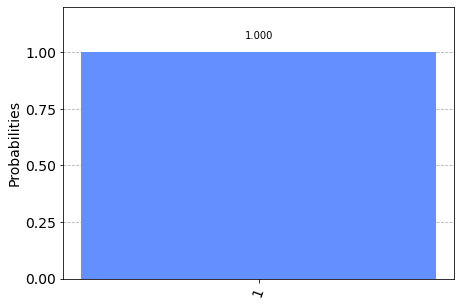

In [ ]:
def and_g(l):
  n=len(l)
  inp = QuantumRegister(n,"input")
  out = QuantumRegister(1,"out")
  cla = ClassicalRegister(1,"cla")
  qc = QuantumCircuit(inp,out,cla)
  for i in range(n):
    qc.x(i)
  qc.barrier()
  for i in range(n):
    if(int(l[i])==1):
      qc.x(i)
  qc.barrier()
  qc.mcx(inp,out)
  qc.barrier()
  for i in range(n):
    qc.x(i)
  qc.x(out)
  qc.measure(out,cla)
  print(qc.draw())
  aer_sim = Aer.get_backend('aer_simulator')
  transpiled_qc = transpile(qc, aer_sim)
  qobj = assemble(transpiled_qc)
  job = aer_sim.run(qobj)
  hist = job.result().get_counts()
  return hist

plot_histogram(and_g("010"))

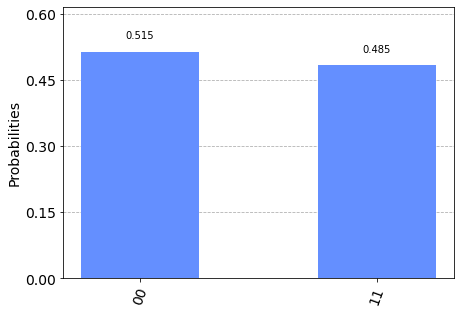

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw()
qc.measure_all()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

        ┌───┐     ┌───┐┌───┐     ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■──┤ Z ├┤ X ├──■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├──────────┤ X ├──────░──╫─┤M├
             └───┘          └───┘      ░  ║ └╥┘
meas: 2/══════════════════════════════════╩══╩═
                                          0  1 


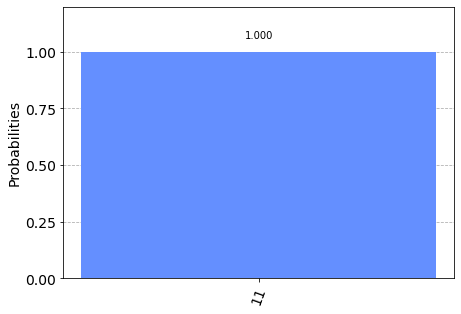

In [ ]:
def eva():
  qc=QuantumCircuit(2)
  qc.h(0)
  qc.cx(0,1)
  return qc

def alice(qc,q,mess):
  #00 identità
  if(mess[0] and mess[0]):
    pass
  #10 identità
  if(int(mess[1])==1):
    qc.z(q)
  #01 identità
  if(int(mess[0])==1):
    qc.x(q)
  
  return qc

def bob(qc):
  qc.cx(0,1)
  qc.h(0)
  #qc.measure_all()
  return qc

#messaggio
mess = "11"
q_c = eva()
#Codifica di ALice
alice_gate = alice(q_c,0,mess)
#Decodifica Bob
result = bob(alice_gate)
#misuro
result.measure_all()
print(result.draw())
#simulo
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(result, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)